## Sensitivity Analysis: SECIR six groups

This notebook performs a sensitivty analyis for the SECIR model that uses six different age groups.

In [1]:
import memilio.simulation.secir as secir
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn")
from datetime import datetime

In [2]:
from __future__ import print_function
import openturns as ot
import openturns.viewer as viewer
from matplotlib import pylab as plt
ot.Log.Show(ot.Log.NONE)

In [3]:
# define input factors and their distributions

input_factor_names = ["incubation_time", 
                 "infectious_mild_time", 
                 "serial_interval", 
                 "hospitalized_to_home_time", 
                 "home_to_hospitalized_time",
                 "hospitalized_to_icu_time", 
                 "icu_to_home_time", 
                 "icu_to_death_time"
                ]

dimension = len(input_factor_names)

coll = [ot.Uniform(4, 6),
         ot.Uniform(4, 8),
         ot.Uniform(3.5, 5.5),
         ot.Normal(9, 4),
         ot.Normal(7, 4),
         ot.Normal(3, 4),
         ot.Normal(9, 4),
         ot.Normal(8, 4)]

inputDistribution = ot.ComposedDistribution(coll)
inputDistribution.setDescription(input_factor_names)

size = 1000

X = inputDistribution.getSample(size)
#print(X)

In [4]:
print(type(X))
print(len(X))
print(X[0,0])
print(X[1])

<class 'openturns.typ.Sample'>
1000
5.259753113215554
[5.76561,4.60445,4.27553,5.14642,11.3618,3.17803,10.528,3.80657]


In [5]:

def run_secir_groups_simulation():
    """
    Runs the c++ secir model using mulitple age groups 
    and plots the results
    """

    # Initialize Parameters
    model = SecirModel(len(populations))

    # set parameters
    for i in range(num_groups):
        # Compartment transition duration

        model.parameters.IncubationTime[AgeGroup(i)] = 5.2  # R_2^(-1)+R_3^(-1)
        model.parameters.InfectiousTimeMild[AgeGroup(
            i)] = 6.  # 4-14  (=R4^(-1))
        # 4-4.4 // R_2^(-1)+0.5*R_3^(-1)
        model.parameters.SerialInterval[AgeGroup(i)] = 4.2
        model.parameters.HospitalizedToHomeTime[AgeGroup(
            i)] = 12.  # 7-16 (=R5^(-1))
        model.parameters.HomeToHospitalizedTime[AgeGroup(
            i)] = 5.  # 2.5-7 (=R6^(-1))
        model.parameters.HospitalizedToICUTime[AgeGroup(
            i)] = 2.  # 1-3.5 (=R7^(-1))
        model.parameters.ICUToHomeTime[AgeGroup(i)] = 8.  # 5-16 (=R8^(-1))
        model.parameters.ICUToDeathTime[AgeGroup(i)] = 5.  # 3.5-7 (=R5^(-1))

        # Initial number of peaople in each compartment
        model.populations[AgeGroup(
            i), Index_InfectionState(State.Exposed)] = 100
        model.populations[AgeGroup(
            i), Index_InfectionState(State.Carrier)] = 50
        model.populations[AgeGroup(
            i), Index_InfectionState(State.Infected)] = 50
        model.populations[AgeGroup(i), Index_InfectionState(
            State.Hospitalized)] = 20
        model.populations[AgeGroup(i), Index_InfectionState(State.ICU)] = 10
        model.populations[AgeGroup(
            i), Index_InfectionState(State.Recovered)] = 10
        model.populations[AgeGroup(i), Index_InfectionState(State.Dead)] = 0
        model.populations.set_difference_from_total(
            (AgeGroup(i), Index_InfectionState(State.Susceptible)), populations[i])

        # Compartment transition propabilities

        model.parameters.RelativeCarrierInfectability[AgeGroup(i)] = 0.67
        model.parameters.InfectionProbabilityFromContact[AgeGroup(i)] = 1.0
        model.parameters.AsymptoticCasesPerInfectious[AgeGroup(
            i)] = 0.09  # 0.01-0.16
        model.parameters.RiskOfInfectionFromSympomatic[AgeGroup(
            i)] = 0.25  # 0.05-0.5
        model.parameters.HospitalizedCasesPerInfectious[AgeGroup(
            i)] = 0.2  # 0.1-0.35
        model.parameters.ICUCasesPerHospitalized[AgeGroup(
            i)] = 0.25  # 0.15-0.4
        model.parameters.DeathsPerICU[AgeGroup(i)] = 0.3  # 0.15-0.77
        # twice the value of RiskOfInfectionFromSymptomatic
        model.parameters.MaxRiskOfInfectionFromSympomatic[AgeGroup(i)] = 0.5

    model.parameters.StartDay = (
        date(start_year, start_month, start_day) - date(start_year, 1, 1)).days

    # set contact rates and emulate some mitigations
    # set contact frequency matrix
    model.parameters.ContactPatterns.cont_freq_mat[0].baseline = np.loadtxt(baseline_contact_matrix0) \
        + np.loadtxt(baseline_contact_matrix1) + \
        np.loadtxt(baseline_contact_matrix2) + \
        np.loadtxt(baseline_contact_matrix3)
    model.parameters.ContactPatterns.cont_freq_mat[0].minimum = np.ones(
        (num_groups, num_groups)) * 0
    model.parameters.ContactPatterns.cont_freq_mat.add_damping(Damping(
        coeffs=np.ones((num_groups, num_groups)) * 0.9, t=30.0, level=0, type=0))

    # Apply mathematical constraints to parameters
    model.apply_constraints()

    # Run Simulation
    result = simulate(0, days, dt, model)
    # print(result.get_last_value())

    num_time_points = result.get_num_time_points()
    result_array = result.as_ndarray()
    t = result_array[0, :]
    group_data = np.transpose(result_array[1:, :])

    # sum over all groups
    data = np.zeros((num_time_points, num_compartments))
    for i in range(num_groups):
        data += group_data[:, i * num_compartments: (i + 1) * num_compartments]
    
    infections = data[:, compartments.index("Infected")]
    
    return np.max(infections)

    # return data

In [18]:
# define static parameters of the model

# Define Comartment names
compartments = ['Susceptible', 'Exposed', 'Carrier', 'Infected', 'Hospitalized', 'ICU', 'Recovered', 'Dead']
# Define age Groups
groups = ['0-4', '5-14', '15-34', '35-59', '60-79', '80+']
# Define population of age groups
populations = [40000, 70000, 190000, 290000, 180000, 60000] 

days = 100 # number of days to simulate
start_day = 1
start_month = 1
start_year = 2019
dt = 0.1
num_groups = len(groups)
num_compartments = len(compartments)

# set contact frequency matrix
baseline_contact_matrix0 = "../../data/contacts/baseline_home.txt"
baseline_contact_matrix1 = "../../data/contacts/baseline_school_pf_eig.txt"
baseline_contact_matrix2 = "../../data/contacts/baseline_work.txt"
baseline_contact_matrix3 = "../../data/contacts/baseline_other.txt"

baseline_contact_matrix = np.loadtxt(baseline_contact_matrix0) \
        + np.loadtxt(baseline_contact_matrix1) \
        + np.loadtxt(baseline_contact_matrix2) + np.loadtxt(baseline_contact_matrix3)

minimum_contact_matrix = np.ones((num_groups, num_groups)) * 0


# Define Comartment names
compartments = ['Susceptible', 'Exposed', 'Carrier',
                'Infected', 'Hospitalized', 'ICU', 'Recovered', 'Dead']
# Define age Groups
groups = ['0-4', '5-14', '15-34', '35-59', '60-79', '80+']
# Define population of age groups
populations = [40000, 70000, 190000, 290000, 180000, 60000]

days = 100  # number of days to simulate
start_day = 1
start_month = 1
start_year = 2019
dt = 0.1
num_groups = len(groups)
num_compartments = len(compartments)

# set contact frequency matrix
data_dir = os.path.join(os.path.dirname(
    __file__), "..", "..", "..", "data")
baseline_contact_matrix0 = os.path.join(
    data_dir, "contacts/baseline_home.txt")
baseline_contact_matrix1 = os.path.join(
    data_dir, "contacts/baseline_school_pf_eig.txt")
baseline_contact_matrix2 = os.path.join(
    data_dir, "contacts/baseline_work.txt")
baseline_contact_matrix3 = os.path.join(
    data_dir, "contacts/baseline_other.txt")


In [19]:
# function that takes input parameters and returns a scalar model output

def simulate_model(sampledFactors, 
                   compartments = compartments, populations = populations, days = days, 
                   start_day = start_day, start_month = start_month, start_year = start_year, 
                   dt = dt, num_groups = num_groups, num_compartments = num_compartments, 
                   baseline_contact_matrix = baseline_contact_matrix, 
                   minimum_contact_matrix = minimum_contact_matrix):
    

    # Initialize Parameters
    model = secir.SecirModel(num_groups)

    # Set parameters
    for i in range(num_groups):
        # Compartment transition duration
        model.parameters.times[i].set_incubation(sampledFactors[0])
        model.parameters.times[i].set_infectious_mild(sampledFactors[1])
        model.parameters.times[i].set_serialinterval(sampledFactors[2])
        model.parameters.times[i].set_hospitalized_to_home(sampledFactors[3])
        model.parameters.times[i].set_home_to_hospitalized(sampledFactors[4])
        model.parameters.times[i].set_hospitalized_to_icu(sampledFactors[5])
        model.parameters.times[i].set_icu_to_home(sampledFactors[6])
        model.parameters.times[i].set_icu_to_death(sampledFactors[7])

        # Initial number of peaople in each compartment
        model.populations[secir.AgeGroup(i), secir.Index_InfectionState(secir.InfectionState.Exposed)] = 100
        model.populations[secir.AgeGroup(i), secir.Index_InfectionState(secir.InfectionState.Carrier)] = 40
        model.populations[secir.AgeGroup(i), secir.Index_InfectionState(secir.InfectionState.Infected)] = 80
        model.populations[secir.AgeGroup(i), secir.Index_InfectionState(secir.InfectionState.Hospitalized)] = 40
        model.populations[secir.AgeGroup(i), secir.Index_InfectionState(secir.InfectionState.ICU)] = 20
        model.populations[secir.AgeGroup(i), secir.Index_InfectionState(secir.InfectionState.Recovered)] = 7
        model.populations[secir.AgeGroup(i), secir.Index_InfectionState(secir.InfectionState.Dead)] = 3
        model.populations.set_difference_from_group_total_AgeGroup((secir.AgeGroup(i), 
            secir.Index_InfectionState(secir.InfectionState.Susceptible)), populations[i])

         # Compartment transition propabilities
        model.parameters.probabilities[i].set_infection_from_contact(1.0)
        model.parameters.probabilities[i].set_carrier_infectability(0.67)
        model.parameters.probabilities[i].set_asymp_per_infectious(0.09)
        model.parameters.probabilities[i].set_risk_from_symptomatic(0.25)
        model.parameters.probabilities[i].set_hospitalized_per_infectious(0.2)
        model.parameters.probabilities[i].set_icu_per_hospitalized(0.25)
        model.parameters.probabilities[i].set_dead_per_icu(0.3)

    model.parameters.set_start_day(start_day + start_month * 30) # TODO: start day has to adapted more precisely!
    
    # set contact rates and emulate some mitigations
    # set contact frequency matrix
    model.parameters.get_contact_patterns().cont_freq_mat[0].baseline = baseline_contact_matrix
    model.parameters.get_contact_patterns().cont_freq_mat[0].minimum = minimum_contact_matrix

    # Define Damping on Contacts
    model.parameters.get_contact_patterns().cont_freq_mat.add_damping(secir.Damping(np.ones((num_groups, num_groups)) * 0.9, 30, 0, 0))

     # Apply mathematical constraints to parameters
    model.apply_constraints()

    # Run Simulation
    result = secir.simulate(0, days, dt, model)
    
    # return maximal number of infected persons during the given time interval
    num_time_points = result.get_num_time_points()
    result_array = result.as_ndarray()
    t = result_array[0, :]
    group_data = np.transpose(result_array[1:, :])

    #sum over all groups
    data = np.zeros((num_time_points, num_compartments))
    for i in range(num_groups):
        data += group_data[:, i * num_compartments : (i + 1) * num_compartments]
    
    infections = data[:, compartments.index("Infected")]
    
    return np.max(infections)


In [20]:
print(size)

1000


In [21]:
sie = ot.SobolIndicesExperiment(inputDistribution, size)

# generate samples from the input distribution
inputDesign = sie.generate()
input_names = inputDistribution.getDescription()
inputDesign.setDescription(input_names)

print("Sample size: ", inputDesign.getSize())

Sample size:  10000


We see that 10000 function evaluations are required to estimate the first order and total Sobol’ indices. Then we evaluate the outputs corresponding to this design of experiments.

In [22]:
print(inputDesign[0])

[5.90555,5.23206,5.3902,-2.6469,8.11674,-1.93579,-2.96815,10.6265]


In [23]:
output = []
for i in range(inputDesign.getSize()):
    Y = simulate_model(inputDesign[i])
    output.append([Y])
#print(output)
outputDesign = ot.Sample(output)

AttributeError: 'memilio._simulation_secir.SecirParams' object has no attribute 'times'

In [9]:
sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(inputDesign, outputDesign, size)

In [10]:
output_dimension = 1
for i in range(output_dimension):
    print("Output #", i)
    first_order = sensitivityAnalysis.getFirstOrderIndices(i)
    total_order = sensitivityAnalysis.getTotalOrderIndices(i)
    print("    First order indices: ", first_order)
    print("    Total order indices: ", total_order)

agg_first_order = sensitivityAnalysis.getAggregatedFirstOrderIndices()
agg_total_order = sensitivityAnalysis.getAggregatedTotalOrderIndices()
print("Agg. first order indices: ", agg_first_order)
print("Agg. total order indices: ", agg_total_order)

Output # 0
    First order indices:  [0.04248,0.265959,-0.0561478,-0.0713164,0.505039,-0.0713592,-0.0713186,-0.0713099]
    Total order indices:  [0.116522,0.318541,0.0128668,-1.76143e-06,0.64252,-7.86931e-06,1.18975e-05,8.27991e-06]
Agg. first order indices:  [0.04248,0.265959,-0.0561478,-0.0713164,0.505039,-0.0713592,-0.0713186,-0.0713099]
Agg. total order indices:  [0.116522,0.318541,0.0128668,-1.76143e-06,0.64252,-7.86931e-06,1.18975e-05,8.27991e-06]


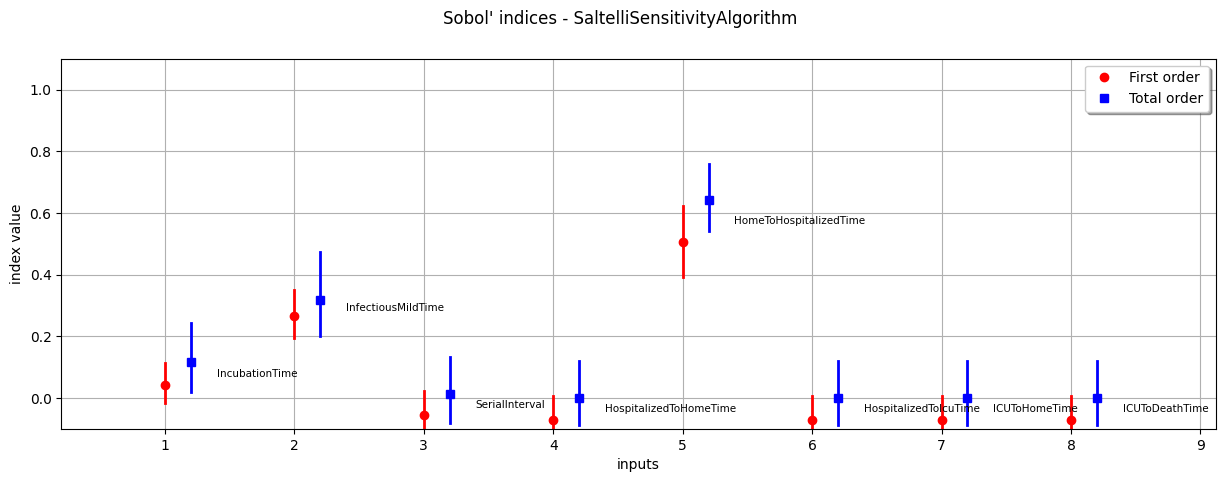

In [12]:
graph = sensitivityAnalysis.draw()
view = viewer.View(graph, (1500, 500))

## Estimate the second order indices

In [13]:
size = 1000
computeSecondOrder = True
sie = ot.SobolIndicesExperiment(inputDistribution, size, computeSecondOrder)
inputDesign = sie.generate()
print("Sample size: ", inputDesign.getSize())
inputDesign.setDescription(input_names)

Sample size:  18000


In [14]:
output = []
for i in range(inputDesign.getSize()):
    Y = simulate_model(inputDesign[i])
    output.append([Y])

In [15]:
outputDesign = ot.Sample(output)

In [16]:
sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(inputDesign, outputDesign, size)

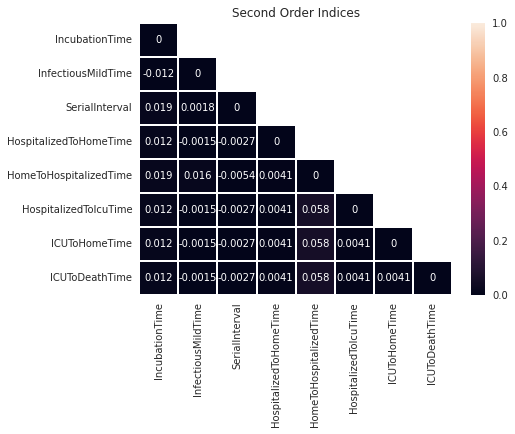

In [31]:
second_order = sensitivityAnalysis.getSecondOrderIndices()
mask = np.ones_like(second_order)
mask[np.tril_indices_from(mask)] = False
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize = (7,5))
    ax = sns.heatmap(second_order, mask = mask, linewidth = 1, annot = True, 
                           xticklabels = input_factor_names, yticklabels = input_factor_names, vmin = 0, vmax = 1)
    plt.title("Second Order Indices")
    plt.show()

In [17]:
second_order = sensitivityAnalysis.getSecondOrderIndices()
for i in range(len(input_factor_names)):
    for j in range(i):
        print('2nd order indice (%s,%s)=%g' % (input_factor_names[i] ,input_factor_names[j] ,second_order[i,j]))


2nd order indice (InfectiousMildTime,IncubationTime)=-0.0119854
2nd order indice (SerialInterval,IncubationTime)=0.0190444
2nd order indice (SerialInterval,InfectiousMildTime)=0.00176989
2nd order indice (HospitalizedToHomeTime,IncubationTime)=0.0120331
2nd order indice (HospitalizedToHomeTime,InfectiousMildTime)=-0.00149742
2nd order indice (HospitalizedToHomeTime,SerialInterval)=-0.00268044
2nd order indice (HomeToHospitalizedTime,IncubationTime)=0.0189897
2nd order indice (HomeToHospitalizedTime,InfectiousMildTime)=0.0157756
2nd order indice (HomeToHospitalizedTime,SerialInterval)=-0.00543257
2nd order indice (HomeToHospitalizedTime,HospitalizedToHomeTime)=0.00414324
2nd order indice (HospitalizedToIcuTime,IncubationTime)=0.0120365
2nd order indice (HospitalizedToIcuTime,InfectiousMildTime)=-0.00150984
2nd order indice (HospitalizedToIcuTime,SerialInterval)=-0.00268231
2nd order indice (HospitalizedToIcuTime,HospitalizedToHomeTime)=0.00414384
2nd order indice (HospitalizedToIcuTime,

# Cobweb

In [60]:
print(outputDesign.getMin(), outputDesign.getMax(), outputDesign.computeQuantilePerComponent(0.9))

[213.079] [28922.7] [17942]


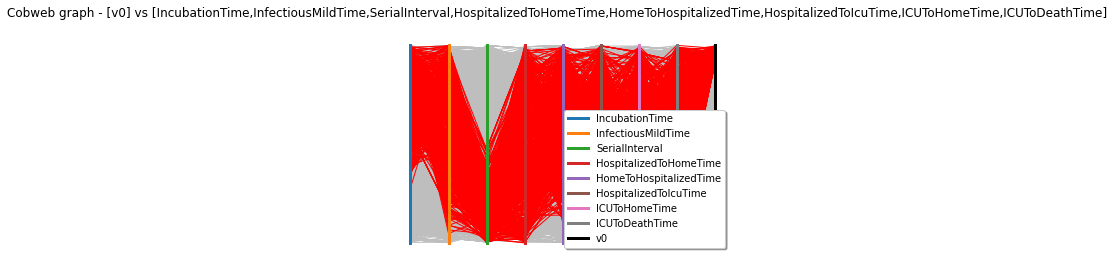

In [63]:
# Example 1: value based scale to describe the Y range

minValue = 17942
maxValue = 30000
quantileScale = False
graphCobweb = ot.VisualTest.DrawCobWeb(inputDesign, outputDesign, minValue, maxValue, 'red', quantileScale)
graphCobweb.setLegendPosition('bottomright')
view = viewer.View(graphCobweb)

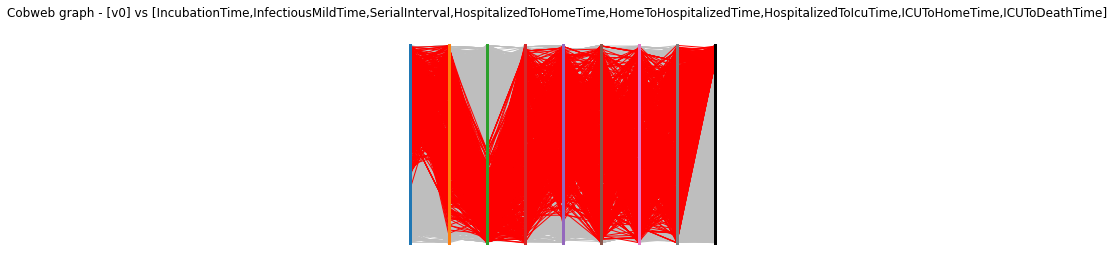

In [70]:
# Example 2: rank based scale to describe the Y range

minValue = 0.9
maxValue = 1.0
quantileScale = True
graphCobweb = ot.VisualTest.DrawCobWeb(inputDesign, outputDesign, minValue, maxValue, 'red', quantileScale)
#graphCobweb.setLegendPosition()
view = viewer.View(graphCobweb, add_legend = False)
plt.show()

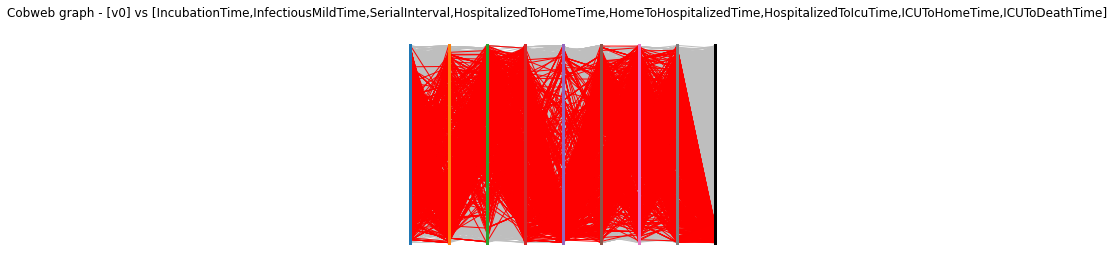

In [71]:
minValue = 0.0
maxValue = 0.1
quantileScale = True
graphCobweb = ot.VisualTest.DrawCobWeb(inputDesign, outputDesign, minValue, maxValue, 'red', quantileScale)
#graphCobweb.setLegendPosition()
view = viewer.View(graphCobweb, add_legend = False)
plt.show()

In [66]:
print(print(ot.Graph.GetValidLegendPositions()))

[,bottomright,bottom,bottomleft,left,topleft,top,topright,right,center]#10
None


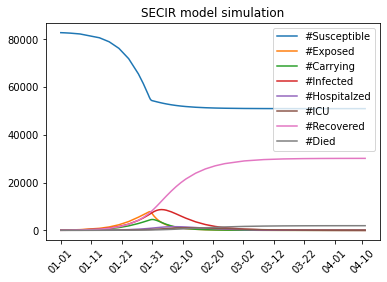

In [3]:
num_time_points = result.get_num_time_points()
result_array = result.as_ndarray()
t = result_array[0, :]
group_data = np.transpose(result_array[1:, :])

#sum over all groups
data = np.zeros((num_time_points,num_compartments))
for i in range(num_groups):
    data += group_data[:, i * num_compartments : (i + 1) * num_compartments]

# Plot Results
datelist = np.array(pd.date_range(datetime(start_year, start_month, start_day), periods=days, freq='D').strftime('%m-%d').tolist())

tick_range = (np.arange(int(days / 10) + 1 ) * 10)
tick_range[-1] -=1
fig, ax = plt.subplots()
ax.plot(t, data[:,0], label='#Susceptible')
ax.plot(t, data[:,1], label='#Exposed')
ax.plot(t, data[:,2], label='#Carrying')
ax.plot(t, data[:,3], label='#Infected')
ax.plot(t, data[:,4], label='#Hospitalzed')
ax.plot(t, data[:,5], label='#ICU')
ax.plot(t, data[:,6], label='#Recovered')
ax.plot(t, data[:,7], label='#Died')
ax.set_title("SECIR model simulation")
ax.set_xticks(tick_range)
ax.set_xticklabels(datelist[tick_range],rotation=45)
ax.legend()
fig.tight_layout
fig.savefig('Secir_simple.pdf')

plt.show()
plt.close()

## Six age groups

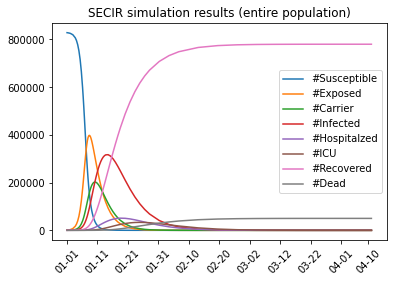

In [5]:
num_time_points = result.get_num_time_points()
result_array = result.as_ndarray()
t = result_array[0, :]
group_data = np.transpose(result_array[1:, :])

# sum over all groups
data = np.zeros((num_time_points, num_compartments))
for i in range(num_groups):
    data += group_data[:, i * num_compartments : (i + 1) * num_compartments]

# Plot Results
datelist = np.array(pd.date_range(datetime(start_year, start_month, start_day), periods=days, freq='D').strftime('%m-%d').tolist())

tick_range = (np.arange(int(days / 10) + 1 ) * 10)
tick_range[-1] -=1
fig, ax = plt.subplots()
ax.plot(t, data[:,0], label='#Susceptible')
ax.plot(t, data[:,1], label='#Exposed')
ax.plot(t, data[:,2], label='#Carrier')
ax.plot(t, data[:,3], label='#Infected')
ax.plot(t, data[:,4], label='#Hospitalzed')
ax.plot(t, data[:,5], label='#ICU')
ax.plot(t, data[:,6], label='#Recovered')
ax.plot(t, data[:,7], label='#Dead')
ax.set_title("SECIR simulation results (entire population)")
ax.set_xticks(tick_range)
ax.set_xticklabels(datelist[tick_range],rotation=45)
ax.legend()
fig.tight_layout
plt.show()

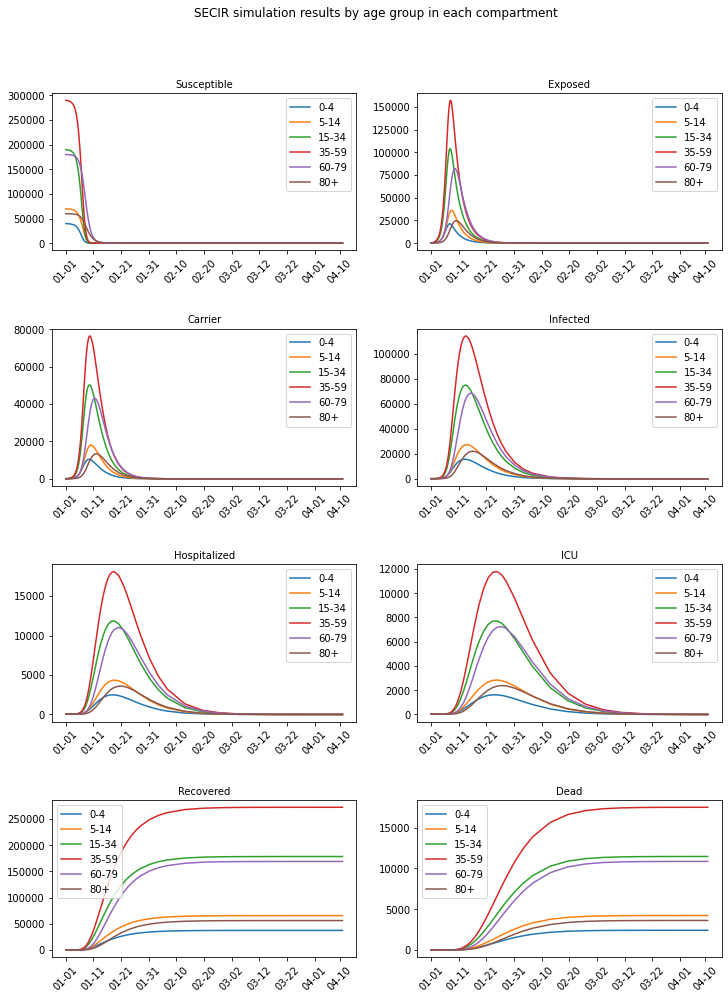

In [6]:
# plot dynamics in each comparment by age group
fig, ax = plt.subplots(4, 2, figsize=(12, 15))

for i, title in zip(range(num_compartments), compartments):

    for j, group in enumerate(groups):
        ax[int(np.floor(i / 2)), int(i % 2)].plot(t, group_data[:, j*num_compartments+i], label = group)

    ax[int(np.floor(i / 2)), int(i % 2)].set_title(title, fontsize=10)
    ax[int(np.floor(i / 2)), int(i % 2)].legend()

    ax[int(np.floor(i / 2)), int(i % 2)].set_xticks(tick_range)
    ax[int(np.floor(i / 2)), int(i % 2)].set_xticklabels(datelist[tick_range], rotation=45)
plt.subplots_adjust(hspace=0.5, bottom=0.1, top=0.9)
fig.suptitle('SECIR simulation results by age group in each compartment')
plt.show()

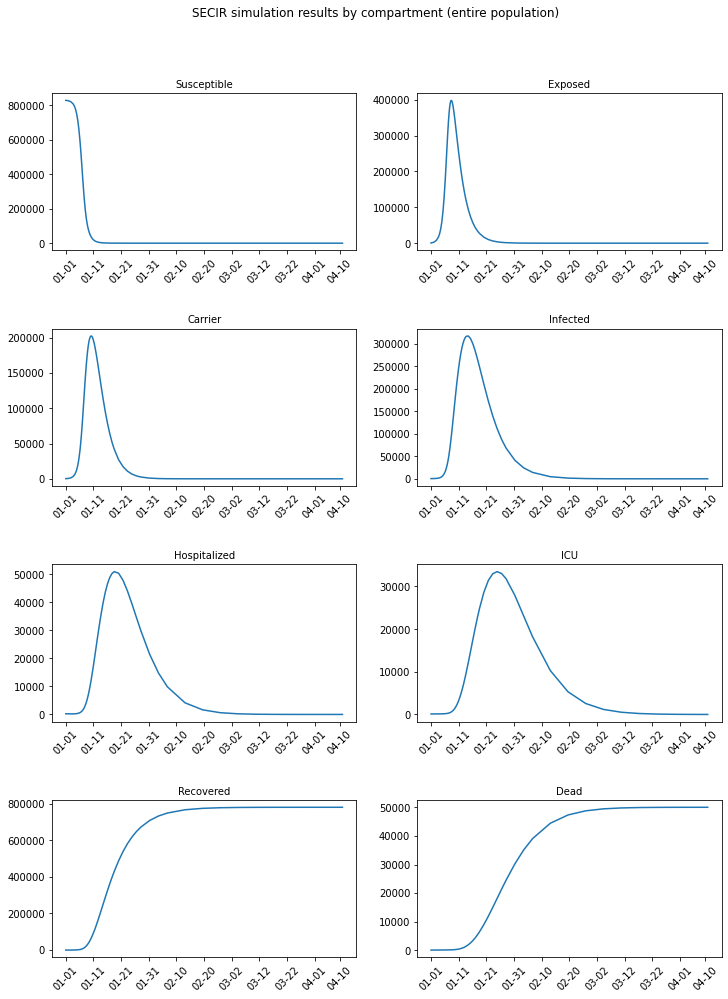

In [7]:
fig, ax = plt.subplots(4, 2, figsize=(12, 15))
for i, title in zip(range(num_compartments), compartments):
    ax[int(np.floor(i / 2)), int(i % 2)].plot(t, data[:, i])
    ax[int(np.floor(i / 2)), int(i % 2)].set_title(title, fontsize=10)

    ax[int(np.floor(i / 2)), int(i % 2)].set_xticks(tick_range)
    ax[int(np.floor(i / 2)), int(i % 2)].set_xticklabels(datelist[tick_range], rotation=45)
plt.subplots_adjust(hspace=0.5, bottom=0.1, top=0.9)
fig.suptitle('SECIR simulation results by compartment (entire population)')
fig.savefig('Secir_all_parts.pdf')

plt.show()
plt.close()